In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Necessary since Colab by default has scikit-learn-0.22.2.post1
# which lacks certain functionality we need
!pip uninstall -y -q sklearn
!pip uninstall -y -q scikit-learn
!pip install -q scikit-learn==0.23.2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
root_path = '/content/drive/My Drive/Colab Notebooks/'
csv_name = 'allAgesBothGenders_412-825_MERGED.csv'
csv_path = os.path.join(root_path, csv_name)

# Data Preparation #

In [ ]:
def read_merged_csv(path):
    df = pd.read_csv(path, parse_dates = ['date'])

    # Two columns that we do not want for any reason.
    df = df.drop(['Unnamed: 0', 'summed_n'], axis = 1)

    # Set the type of the state code column to category
    df.state_code = df.state_code.astype('category')

    # Sort all data by date
    df.sort_values(['date', 'state_code'], inplace = True)
    assert(df.date.is_monotonic_increasing)

    # Find number of NAs by column (of the columns with more than zero NAs)
    nan_counts = df.isna()[list(df.isna().any()[df.isna().any()].index)].sum()
    print(f"Column-wise NA counts:\n\n{nan_counts}\r", end = "")

    # Choose a threshold of number of nans in a given column before we drop them
    # completely. I chose the mean here, because the top three have 500+ nans
    # and the rest each have less than 20 nans
    COL_DROP_NAN_THRESHOLD = len(df) - int(nan_counts.mean())

    # Drop columns with high amounts of NAs (shave off the top of the list
    # nan_counts that was made earlier)
    df_fewer_cols = df.dropna(axis = 1, thresh = COL_DROP_NAN_THRESHOLD)
    num_cols_dropped = len(df.columns) - len(df_fewer_cols.columns)
    print(f" \nDropped {num_cols_dropped} columns with more than {len(df) - int(COL_DROP_NAN_THRESHOLD)} non-NA values:\n",
          f" \n{pd.Series(list(set(list(df.columns)) - set(list(df_fewer_cols.columns))))}\r", end = "")

    # Then drop the rest of the NaNs along the rows (not dropping colummns)
    df_fewer_rows = df_fewer_cols.dropna(axis = 0)
    print(f" \nDropped {len(df) - len(df_fewer_rows)} rows.")

    assert(df_fewer_rows.isna().any().any() == False)
    return df_fewer_rows

In [ ]:
df = read_merged_csv(csv_path)

Column-wise NA counts:

smoothed_pct_cmnty_cli                    463
smoothed_mean_hh_cli_ct                   514
smoothed_mean_cmnty_cli_ct                463
smoothed_pct_tested_and_positive           32
smoothed_pct_tested_and_negative           32
smoothed_pct_tested_no_result              32
smoothed_pct_could_not_get_tested          32
smoothed_pct_did_not_try_to_get_tested     32
 
Dropped 3 columns with more than 200 non-NA values:
  
0    smoothed_mean_cmnty_cli_ct
1       smoothed_mean_hh_cli_ct
2        smoothed_pct_cmnty_cli
 
Dropped 32 rows.


# Define Helper Functions

In [ ]:
# Create a dictionary of all sklearn regression metrics 
from sklearn import metrics
sklearn_regression_metrics = {'r2' : metrics.r2_score}

In [128]:
# Takes a dataframe outputted by read_merged_csv(), the name of the desired
# target-column, and outputs a train-test split snapped to the nearest date
# within the specified test_size percentage. Optionally, you can specify
# whether you want to then shuffle the data within the two train/test
# stratifications. Does not require that the input dataframe be sorted by date
# as this function will sort before splitting.
def train_test_split_on_date(df, y, shuffle_within_splits = True, test_size = 0.2):
    if not df.date.is_monotonic_increasing:
      df = df.sort_values('date')

    split_on_date = df.date.quantile(1 - test_size)

    train = df[df.date < split_on_date]
    test = df[df.date >= split_on_date]

    if shuffle_within_splits:
      train = train.sample(frac = 1)
      test = test.sample(frac = 1)

    X_train = train[train.date < split_on_date].drop(y, axis = 1)
    y_train = train[train.date < split_on_date][y]

    X_test = test[test.date >= split_on_date].drop(y, axis = 1)
    y_test = test[test.date >= split_on_date][y]

    unique_train_states = set(X_train.state_code.unique())
    unique_test_states = set(X_test.state_code.unique())

    if unique_train_states != unique_test_states:
      from IPython.display import display
      display(df)
      display(train)
      display(test)
      msg = f'Found unique train states: {unique_train_states} not equal to unique test states: {unique_test_states}. '
      msg += "Try increasing the test_size parameter."
      raise ValueError(msg)

    return (X_train, y_train, X_test, y_test)

# Takes the y and y_hat for the test (holdout) data and a dictionary of sklearn regression
# metric names and their corresponding functions
def evaluate_regressor(y_test, predictions, sklearn_regression_metrics):
    scores = {}

    for metric_name, metric_func in sklearn_regression_metrics.items():
        scores[metric_name] = metric_func(y_test, predictions)
    
    return scores

# Given an output from evaluate_regressor(), print the results in a pretty way to the
# console
def print_regressor_evaluation(scores):
    padding = 0

    for metric_name in scores.keys():
        padding = len(metric_name) if len(metric_name) > padding else padding
    
    for metric_name, score in scores.items():
        print(f'{metric_name}{" "*(padding - len(metric_name))} = {score:.6f}')
        
# Takes a dataframe and a target column, and shift by a specified number of days for forecasting
def shift_for_forecasting(df, target, days_ahead):
    dfs = []
    gby =  df.groupby('state_code')
    for group in gby.groups:
        group_df = gby.get_group(group)
        group_df = group_df.reset_index(drop = True)
        group_df = group_df.set_index('date')
        group_df[target] = group_df[target].shift(-days_ahead, freq = 'D')
        group_df = group_df.dropna(axis = 0, subset = [target])
        group_df = group_df.reset_index()
        dfs.append(group_df)

    df = pd.concat(dfs)
    df = df.sort_values('date')
    return df

def prepare_df_for_train_test_split(df, task, target, days_ahead = 7):
    # Specify the two target columns that are in df
    target_cols = ['cases_per_m', 'deaths_per_m']
    
    # From df, drop the target column that ISN'T the variable "target" passed into this function
    # There is probably a better way to do this, but we want to make this function versatile
    # and able to take in the base dataframe with both target columns and THEN select the desired target
    # for regression.
    target_cols.pop(target_cols.index(target))
    drop_col = target_cols[0]
    
    try:
        df = df.drop(drop_col, axis = 1)
    except KeyError as e:
        print(f"Positional argument df must have {target_cols} present as columns.")
        raise e
    
    if task == 'forecast':
        # Call our shift_for_forecasting() function
        df = shift_for_forecasting(df, target, days_ahead)
    elif task == 'nowcast':
        pass
    else:
        print(f"Task type {task} not recognized: use task type 'forecast' for forecasting or 'nowcast' for instantaneous prediction.")
        raise NotImplemented
    
    return df
    
# Takes a dataframe, a task ('forecasting' or 'nowcast'), days_ahead (if forecasting) and a time for
# training each model (multiply the time you input by four to get total running time of this function)
def model_training_and_evaluation(df, task, target, model, days_ahead = 7, test_size = 0.2, shuffle = False):
    # Get current time for naming output files in a unique way
    import time
    posix = int(time.time())
    if task == 'forecast':
        print("-----------------------------------------------")
        print(f"Forecasting on {target} with {days_ahead} days ahead: ", end = "")
        model_name = f'{task}_{days_ahead}_{target}_{posix}'
    elif task == 'nowcast':
        model_name = f'{task}_{target}_{posix}'
        print("-----------------------------------------------")
        print(f"Nowcasting on {target}: ", end = "")
    
    # Removes extraneous columns
    df = prepare_df_for_train_test_split(df, task, target, days_ahead = days_ahead)
    
    # Get train-test split and separate X and y
    X_train, y_train, X_test, y_test = train_test_split_on_date(df, target, test_size = test_size)
    
    X_train = X_train.drop('date', axis = 1)
    date_test = X_test.pop('date')
    #X_test = X_test.drop('date', axis = 1)
    
    # Run some assertions to validate that the data is what we expect
    if target == 'cases_per_m':
        assert('deaths_per_m' != y_train.name and 'deaths_per_m' != y_test.name)
    elif target == 'deaths_per_m':
        assert('cases_per_m' != y_train.name and 'cases_per_m' != y_test.name)
    assert('cases_per_m' not in X_train.columns and 'deaths_per_m' not in X_train.columns)
    assert('cases_per_m' not in X_test.columns and 'deaths_per_m' not in X_test.columns)

    # Fit the ml object to the training data
    model.fit(X_train, y_train)
    
    # Gather predictions for test data
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)


    # DELETE ME
    X_test[f'predicted_{target}_{days_ahead}_days_ahead'] = predictions_test
    X_test[f'actual_{target}_{days_ahead}_days_ahead'] = y_test
    X_test['date'] = date_test
    X_test.to_csv(f'/content/drive/My Drive/Colab Notebooks/covidcsv/{target}_{days_ahead}.csv')
    
    # Evaluate predictions
    scores = {}
    scores['test'] = evaluate_regressor(y_test, predictions_test, sklearn_regression_metrics)
    scores['train'] = evaluate_regressor(y_train, predictions_train, sklearn_regression_metrics)
    
    # Print predictions to console
    print(f"test r^2 = {scores['test']['r2']:.2f}, train r^2 = {scores['train']['r2']:.2f}")

    model.task = task
    model.target = target
    model.days_ahead = days_ahead
    model.test_size = test_size
    model.shuffle = shuffle
  
    # Return the sklearn models used in the final ensemble
    return (model, scores)

In [ ]:
def train_all_model_types(df, model, notes = None, days_ahead = [7], test_size = 0.2):
  if notes:
    print(f"{'-'*80}\nNOTE: {notes}\n{'-'*80}")
  results_df_dict = {'algorithm' : [], 'problem_type' : [], 'days_ahead' : [],
                     'target' : [], 'test_pct' :  [], 'r2_train' : [], 'r2_test' : [],
                     'model_obj' : [], 'features_kept' : []}

  for lookahead in days_ahead:
    model_obj, scores = model_training_and_evaluation(df, 'forecast', 'deaths_per_m', model, days_ahead = lookahead, test_size = test_size)
    results_df_dict['algorithm'].append(type(model_obj['regression'].regressor).__name__)
    results_df_dict['problem_type'].append('forecast')
    results_df_dict['days_ahead'].append(lookahead)
    results_df_dict['target'].append('deaths_per_m')
    results_df_dict['test_pct'].append(test_size)
    results_df_dict['r2_test'].append(scores['test']['r2'])
    results_df_dict['r2_train'].append(scores['train']['r2'])
    results_df_dict['model_obj'].append(model_obj)

    try:
      results_df_dict['features_kept'].append(len(model_obj['feature_selection'].keep_cols))
    except:
      results_df_dict['features_kept'].append('all')

    model_obj, scores = model_training_and_evaluation(df, 'forecast', 'cases_per_m', model, days_ahead = lookahead, test_size = test_size)
    results_df_dict['algorithm'].append(type(model_obj['regression'].regressor).__name__)
    results_df_dict['problem_type'].append('forecast')
    results_df_dict['days_ahead'].append(lookahead)
    results_df_dict['target'].append('cases_per_m')
    results_df_dict['test_pct'].append(test_size)
    results_df_dict['r2_test'].append(scores['test']['r2'])
    results_df_dict['r2_train'].append(scores['train']['r2'])
    results_df_dict['model_obj'].append(model_obj)

    try:
      results_df_dict['features_kept'].append(len(model_obj['feature_selection'].keep_cols))
    except:
      results_df_dict['features_kept'].append('all')

  model_obj, scores = model_training_and_evaluation(df, 'nowcast', 'deaths_per_m', model, test_size = test_size)
  results_df_dict['algorithm'].append(type(model_obj['regression'].regressor).__name__)
  results_df_dict['problem_type'].append('nowcast')
  results_df_dict['days_ahead'].append(0)
  results_df_dict['target'].append('deaths_per_m')
  results_df_dict['test_pct'].append(test_size)
  results_df_dict['r2_test'].append(scores['test']['r2'])
  results_df_dict['r2_train'].append(scores['train']['r2'])
  results_df_dict['model_obj'].append(model_obj)

  try:
    results_df_dict['features_kept'].append(len(model_obj['feature_selection'].keep_cols))
  except:
    results_df_dict['features_kept'].append('all')

  model_obj, scores = model_training_and_evaluation(df, 'nowcast', 'cases_per_m', model, test_size = test_size)
  results_df_dict['algorithm'].append(type(model_obj['regression'].regressor).__name__)
  results_df_dict['problem_type'].append('nowcast')
  results_df_dict['days_ahead'].append(0)
  results_df_dict['target'].append('cases_per_m')
  results_df_dict['test_pct'].append(test_size)
  results_df_dict['r2_test'].append(scores['test']['r2'])
  results_df_dict['r2_train'].append(scores['train']['r2'])
  results_df_dict['model_obj'].append(model_obj)

  try:
    results_df_dict['features_kept'].append(len(model_obj['feature_selection'].keep_cols))
  except:
    results_df_dict['features_kept'].append('all')

  return pd.DataFrame(results_df_dict)

# Scikit-Learn Pipeline

## Feature Selection 



Let's take a look at the shape of our dataset:

In [ ]:
df.shape

(7014, 99)

With 7,014 rows and 99 feature columns, our dataset has a fairly high observation-to-feature ratio, so we consider some form of dimensionality reduction. The benefit of reducing the dataset's dimensionality is two-fold. First, reducing the number of features will reduce the Bayesian information criterion (![BIC](https://wikimedia.org/api/rest_v1/media/math/render/svg/9fb26ce833300f98a6df6039624fc7ffaf4ce7fb). This limit the risk of overfitting to the test set for any model choice, increasing overall generalizability. Second, the results of feature selection will help inform future epidemiological studies to streamline their survey methodology. Reducing survey time without loss of information provides the researcher with more data while reducing the personal expense to the survey-taker. However, this demands that we retain the features themselves rather than projecting their combinations to a lower dimension, ruling out PCA or non-linear dimensionality reduction techniques.

Hence, we employ a custom feature selection algorithm that approximates the optimal set of features based on their importances within a fitted XGBoost regression model. The algorithm works as follows:

1. Fit an XGBRegressor to the first 80% of the training set (64% of the full dataset) using all `N` of the available features.
2. Sort a list of features `G` by their gain within the fitted model (where the gain of a feature is the average increase in accuracy achieved
by all branches using that feature).
3. Train `N` XGBRegressor models, where the `N - k`th model uses the top `N - k` features from `G`, and `k` ranges from `0` to `N - 1`.
4. Test each model against the last 20% of the train data (16% of the original data).
5. Select the feature set `F` that corresponds to the highest performing model (assessed by R^2) and return `F`.

Thus this algorithm satisfies our requirements of reducing the dimensionality (to minimize the BIC) while preserving the original feature scales (to maximize interpretability). We justify the use of XGBoost as a feature selection tool due to the feature selection mechanism embedded within all regularized tree models. Theoretically, any model with embedded feature selection mechanisms would satisfy these requirements, such as L1-regularized SVM or local-learning schemes.

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator

''' 
SKLearn transformer that selects the set of N features for which the highest R^2
is achieved when selected from a list sorted by their respective XGBoost gain
values, where the gain of a feature is the average increase in accuracy achieved
by all split in branches using that feature.
'''
class XGBoostGainSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.keep_cols = []
      
    def get_optimal_feature_set(self, X, y = None):
      X = pd.DataFrame(X)
      y = pd.DataFrame(y)

      split = int(len(X)*0.8)

      test_x = X.iloc[0:split,]
      test_y = y.iloc[0:split,]

      train_x = X.iloc[split:,]
      train_y = y.iloc[split:,]

      from xgboost import XGBRegressor
      xgb_for_importance = XGBRegressor(silent=True, tree_method = 'gpu_hist')
      xgb_for_importance.fit(train_x, train_y, verbose = False)
      pred_y = xgb_for_importance.predict(test_x)
      
      feature_scores = xgb_for_importance.get_booster().get_score(importance_type = 'gain')
      
      import operator
      sorted_feature_scores = sorted(feature_scores.items(), key = operator.itemgetter(1))
      ft = [int(i[0]) for i in sorted_feature_scores]

      train_XX = train_x
      test_XX = test_x
      train_XX = train_XX[ft]
      test_XX = test_XX[ft]
      r2 = []
      n = []
      for feature,score in sorted_feature_scores[:-1]:
        feature = int(feature)
        train_XX=train_XX.drop([feature], axis = 1)

        # train model
        selection_model = XGBRegressor(silent=True, tree_method = 'gpu_hist')
        selection_model.fit(train_XX, train_y)

        # eval model
        test_XX = test_XX.drop([feature],axis=1)
        y_pred = selection_model.predict(test_XX)

        from sklearn.metrics import r2_score
        r2.append(r2_score(y_pred,test_y))
        n.append(train_XX.shape[1])

      max_r2 = max(r2)
      index = np.argmax(r2)
      optimal_n = n[index]

      self.keep_cols = ft[-optimal_n:]
      self.keep_cols = [int(n) for n in self.keep_cols]
      return self
  
    def fit(self, X, y = None):
      self.get_optimal_feature_set(X, y = y)
      return self

    def transform(self, X, y = None, **kwargs):
      return X[:,self.keep_cols]

    def fit_transform(self, X, y = None):
      self.fit(X, y)
      return self.transform(X)

## Preprocessing

**Feature Transformation**

We now examine the distributions of each of our features. We find that most features are unimodal with minimal skew, except for the heavily right-skewed features involving survey responses relating to testing (in the last and second-to-last rows), the features with exceptionally tight spread in the first and second rows, and the severely left-skewed feature `smoothed_pct_did_not_try_to_get_tested` at the end of the 5th row.

Features relating to testing mostly possess a higher level of right skew, suggesting we apply a log transform the offending remaining members of this class of testing-related features. Additionally, the one left-skewed feature suggests a root transform.

The rest of the features can safely be standardized with no additional transformations, since their biggest differences are in their spread, which can be accounted for when we standardize.

In sum, we have the following classes of features of interest:


*Severely right-skewed - (log trasnform)*
- `smoothed_pct_tested_and_negative`
- `smoothed_pct_tested_and_negative_weighted`
- `smoothed_pct_tested_and_positive`
- `smoothed_pct_tested_and_positive_weighted`
- `smoothed_pct_tested_no_result`
- `smoothed_pct_tested_no_result_weighted`

*Severely left-skewed - root transform*
- `smoothed_pct_did_not_try_to_get_tested`

*Exceptionally tight spread - no additional transformation*
- `smoothed_mean_cmnty_cli_ct_weighted`
- `smoothed_mean_hh_cli_ct_weighted`
- `smoothed_mean_outside_hh_contact_at_work_ct`
- `smoothed_mean_outside_hh_contact_at_work_ct_weighted`
- `smoothed_mean_outside_hh_contact_in_social_ct`
- `smoothed_mean_outside_hh_contact_in_social_gatherings_ct_weighted`
- `smoothed_mean_outside_hh_contact_shopping_ct`
- `smoothed_mean_outside_hh_contact_shopping_ct_weighted`

*Remaining features - no additional transformation*

Working on plot...


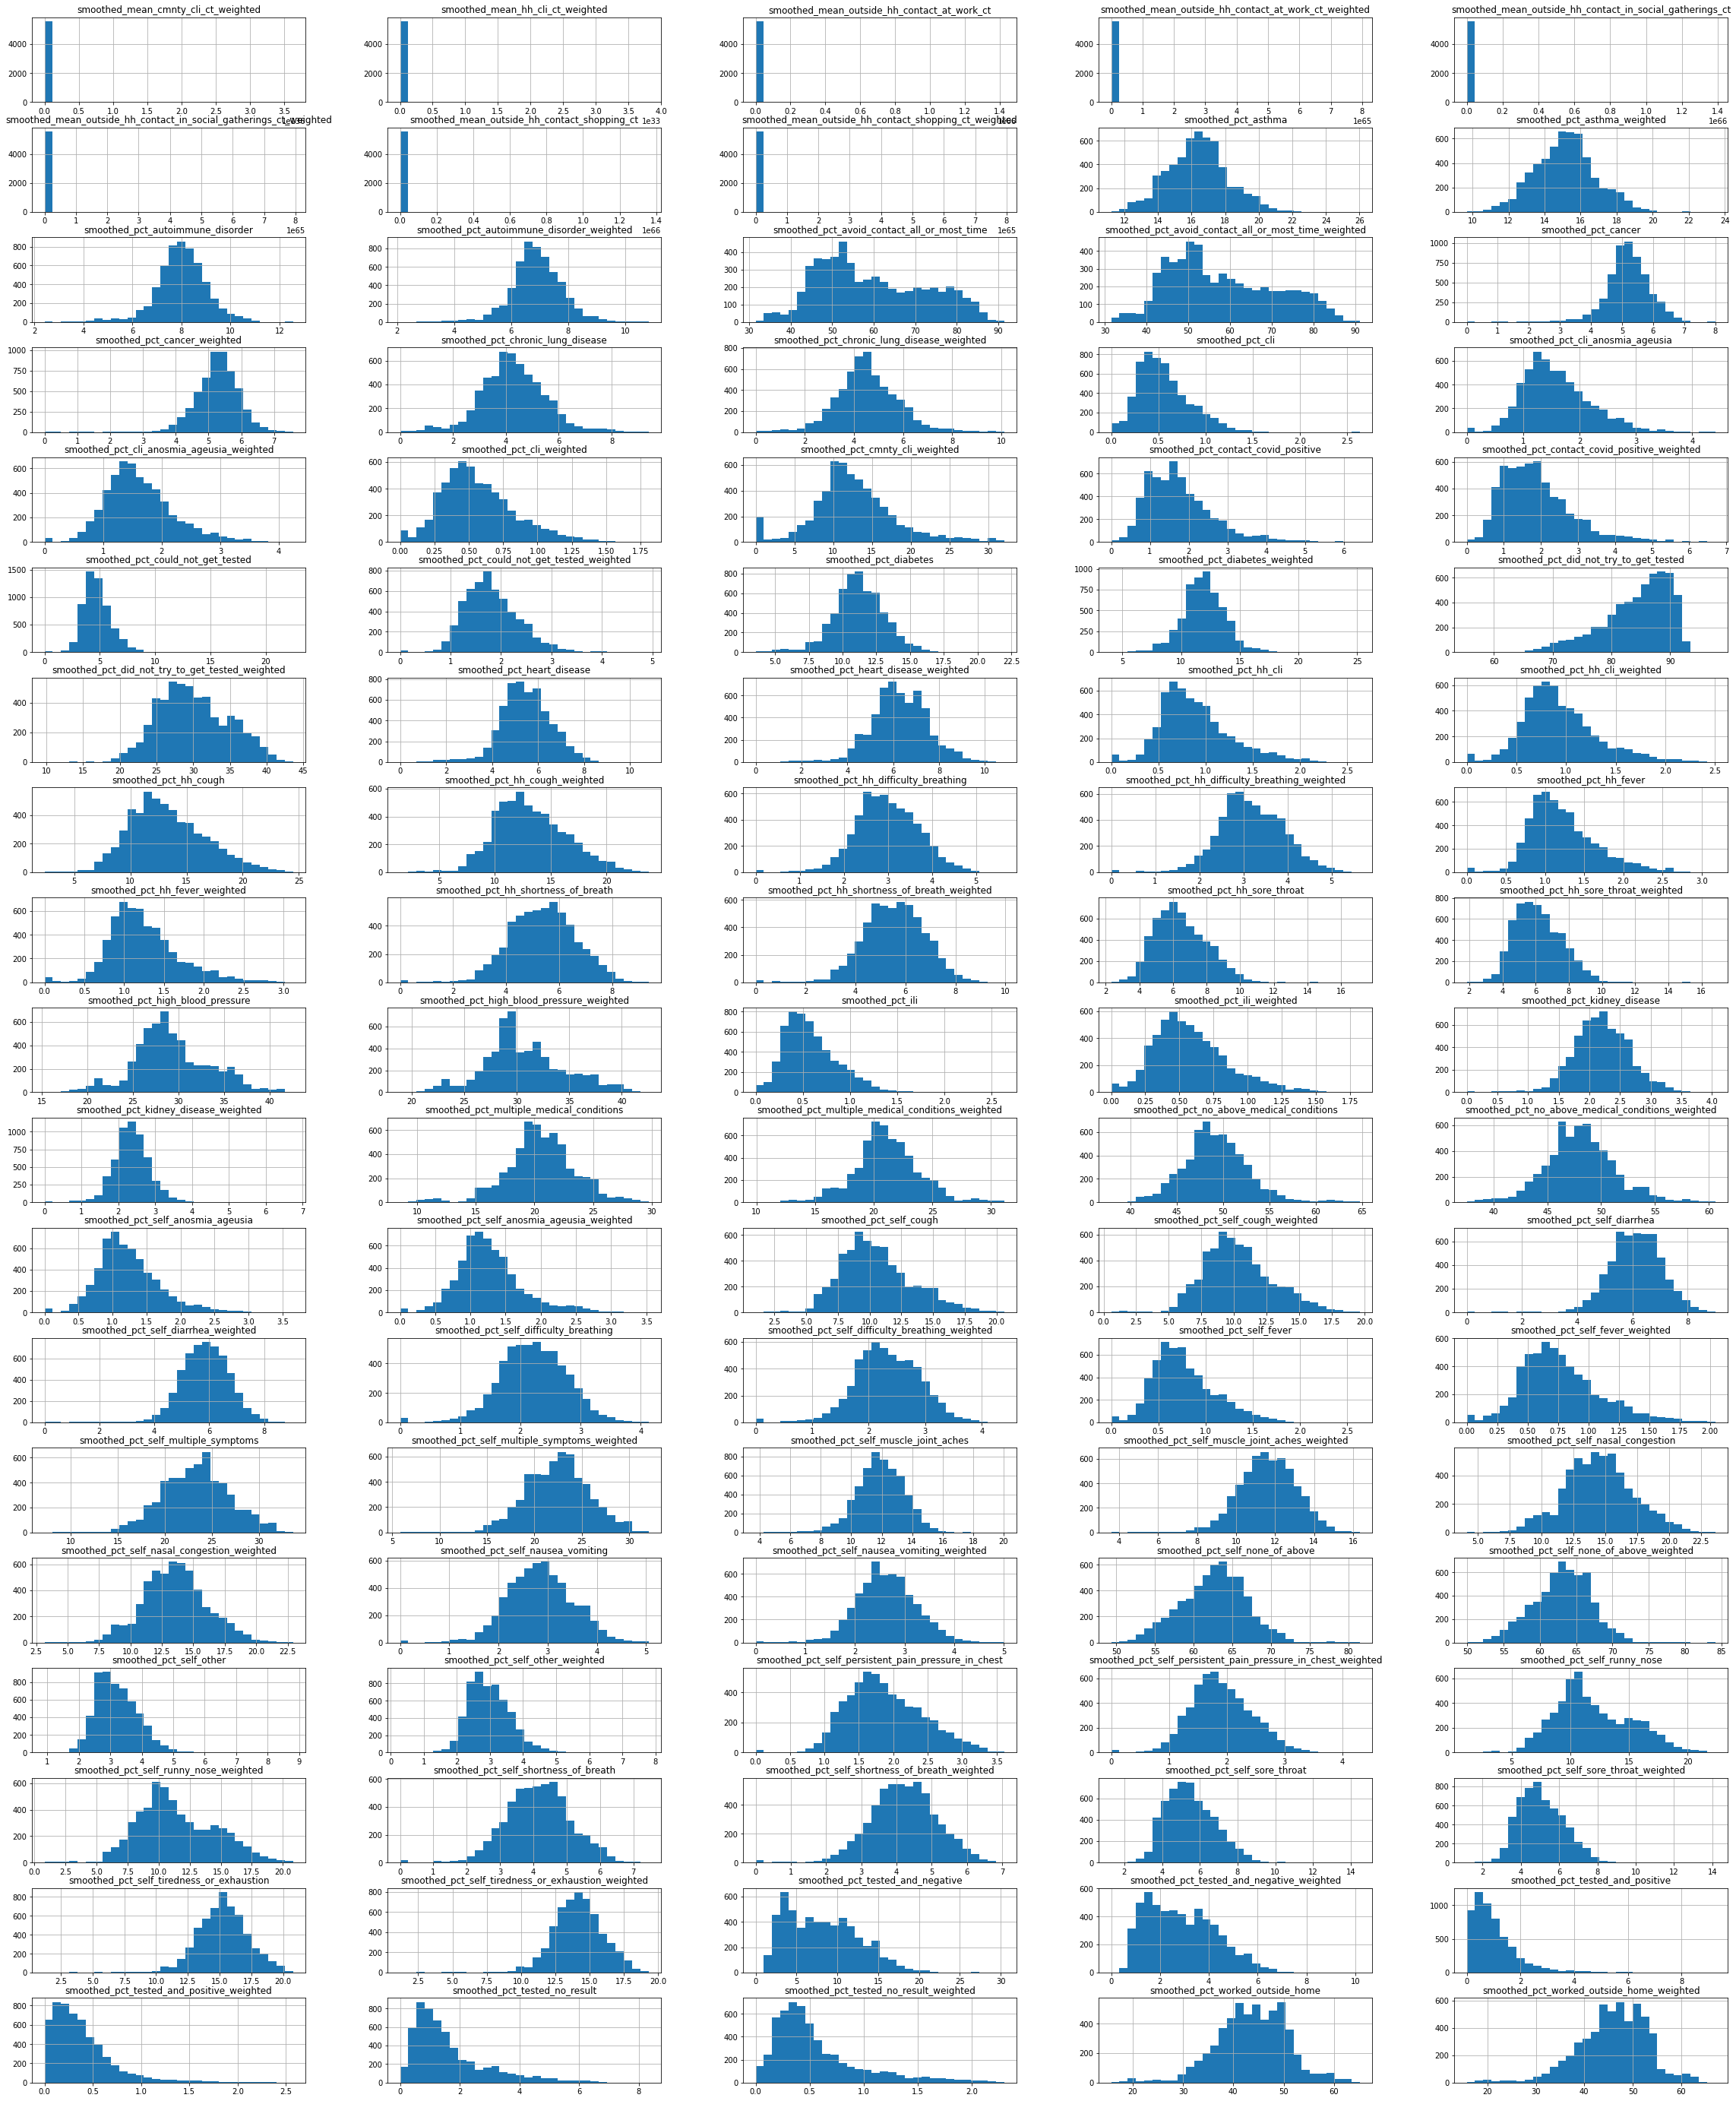

In [ ]:
import numpy as np
import scipy.stats as st

df_deaths = prepare_df_for_train_test_split(df, 'nowcast', 'deaths_per_m')
X_train, _, _, _ = train_test_split_on_date(df, 'deaths_per_m')

X_train = X_train.drop(['date', 'state_code', 'cases_per_m'], axis = 1)

import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots(19, 5, figsize = (40, 50))
X_train.hist(ax = axis, bins = 30)
!clear
print("Working on plot...")
plt.show()

**Target Transformation**

We examine the results of applying a log transform to the target variables `deaths_per_m` and `cases_per_m`, which are both heavily right-skewed. A log transform successfully reduces the skew.

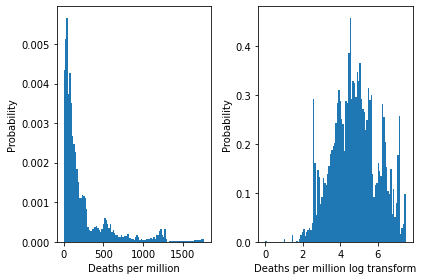

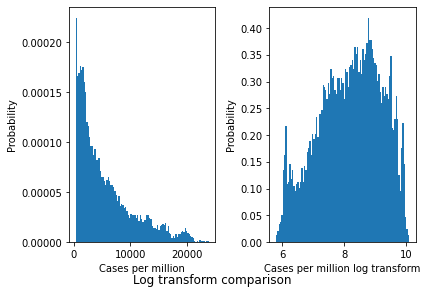

In [ ]:
import random
from matplotlib import pyplot

df_deaths = prepare_df_for_train_test_split(df, 'nowcast', 'deaths_per_m')
_, y_train_deaths, _, _ = train_test_split_on_date(df, 'deaths_per_m')

df_cases = prepare_df_for_train_test_split(df, 'nowcast', 'cases_per_m')
_, y_train_cases, _, _ = train_test_split_on_date(df, 'cases_per_m')

from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np

deaths_trans  = np.log1p(y_train_deaths)
cases_trans = np.log1p(y_train_cases)

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y_train_deaths, bins=100, density = True)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Deaths per million')
#ax0.set_title('Target distribution')

ax1.hist(deaths_trans, bins=100, density = True)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Deaths per million log transform')
#ax1.set_title('Transformed target distribution')

#f.suptitle("Deaths per million log transform ", y = 0.035)
f.tight_layout()#rect=[0.001, 0.001, 0.99, 0.99])


f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y_train_cases, bins=100, density = True)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Cases per million')
#ax0.set_title('Target distribution')

ax1.hist(cases_trans, bins=100, density = True)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Cases per million log transform')
#ax1.set_title('Transformed target distribution')

f.suptitle("Log transform comparison", y = 0.035)
f.tight_layout()#rect=[0.05, 0.05, 0.95, 0.95])

## Build Pipeline

We are now ready to assemble a general pipeline template for training and testing various models. We apply the feature preprocessing steps outlined in the `Preprocessing` section above, but leave out the log transform of the target variable. This is because upon testing, the log transform reduced the R^2 on our validation set by about 0.2 for all experimental setups. This effect may be due to information encoded within the distances between the non-transformed target values that is lost when applying the log transform.

In [ ]:
from sklearn.pipeline import Pipeline

# Define standard pipeline
def make_regression_pipeline(regressor, feature_selector = None):
  from sklearn.compose import TransformedTargetRegressor
  from sklearn.preprocessing import RobustScaler

  from sklearn.compose import ColumnTransformer
  from sklearn.preprocessing import OneHotEncoder
  from sklearn.preprocessing import StandardScaler
  from sklearn.preprocessing import FunctionTransformer

  right_skewed = ['smoothed_pct_tested_and_negative',
                  'smoothed_pct_tested_and_negative_weighted',
                  'smoothed_pct_tested_and_positive',
                  'smoothed_pct_tested_and_positive_weighted',
                  'smoothed_pct_tested_no_result',
                  'smoothed_pct_tested_no_result_weighted']

  left_skewed = ['smoothed_pct_did_not_try_to_get_tested']

  log_transformer = Pipeline(steps=[
      ('log', FunctionTransformer(np.log1p))
  ])

  sqrt_transformer = Pipeline(steps=[
      ('sqrt', FunctionTransformer(np.sqrt))
  ])

  numeric_transformer = Pipeline(steps=[
      ('standardizer', StandardScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('one_hot', OneHotEncoder(dtype = 'int'))
  ])

  from sklearn.compose import make_column_selector as selector
  preprocessor = ColumnTransformer(
      transformers=[
          ('log_transform', log_transformer, right_skewed),
          ('sqrt_transform', sqrt_transformer, left_skewed),
          ('numeric', numeric_transformer, selector(dtype_exclude = "category")),
          ('categorical', categorical_transformer, selector(dtype_include = "category"))])


  '''
  TransformedTargetRegressor transforms the targets y before fitting a
  regression model. The predictions are mapped back to the original space via an
  inverse transform. It takes as an argument the regressor that will be used for
  prediction, and the transformer that will be applied to the target variable.
  '''
  target_transformer = StandardScaler()

  transformed_regressor = TransformedTargetRegressor(regressor = regressor,
                                                     transformer = target_transformer)

  if feature_selector:
    steps = [('feature_transform', preprocessor),
            ('feature_selection', feature_selector),
            ('regression', transformed_regressor)]
  else:
    steps = [('feature_transform', preprocessor),
             ('regression', transformed_regressor)]

  regression_pipeline = Pipeline(steps = steps)
  return regression_pipeline

Let's visualize the steps of the (unfitted) pipeline, graphically, substituting an SVR in for the (arbitrary) regressor. Click on each element to explore its parameters.

In [ ]:
from sklearn import set_config
set_config(display = 'diagram')
from sklearn import svm

svc_pipeline = make_regression_pipeline(svm.SVR(),
                                        XGBoostGainSelector())
print("General pipeline: \n")
svc_pipeline

General pipeline: 



Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('log_transform',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['smoothed_pct_tested_and_negative',
                                                   'smoothed_pct_tested_and_negative_weighted',
                                                   'smoothed_pct_tested_and_positive',
                                                   'smoothed_pct_tested_and_positive_weighted',
                                                   'smoothed_pct_tested_no_result',
                                                   'smoot...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7a755b7be0>),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(dtype='int'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7a755b7a20>)])),
                ('feature_selection', XGBoostGainSelector()),
                ('regression',
                 TransformedTargetRegressor(regressor=<__main__.Regressor object at 0x7f7a7a9ddef0>,
                                            transformer=StandardScaler()))])

# Modeling Results

In [129]:
def run_all_experiments(regressors, df, days_ahead = [7], test_size = 0.2):
  results = pd.DataFrame()

  for regressor_name, regressor in regressors:
    pipeline_0 = make_regression_pipeline(regressor, feature_selector = None)
    pipeline_1 = make_regression_pipeline(regressor, feature_selector = XGBoostGainSelector())

    results_no_selection = train_all_model_types(
        df, pipeline_0,
        notes = f"Training {regressor_name}. No feature selection.",
        days_ahead = days_ahead,
        test_size = test_size)
    
    results_no_selection['feature_selection'] = False
    
    results_with_selection = train_all_model_types(
        df, pipeline_1,
        notes = f"Training {regressor_name}. XGBoost feature selection.",
        days_ahead = days_ahead,
        test_size = test_size)
    results_with_selection['feature_selection'] = True

    results = results.append(results_no_selection.append(results_with_selection, ignore_index = True), ignore_index = True)

  return results

from sklearn import svm
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor as KNN

# Arbitrary regressors that satisfy the Sklearn API
XGB_objective = 'reg:squarederror'
XGB_param = {'objective' : 'reg:squarederror',
             'max_depth' : 4,
             'eta' : 0.03}

regressors = [('XGBRegressor', XGBRegressor(objective = 'reg:squarederror', tree_method = 'gpu_hist'))#,
              #('SVR', svm.SVR()),
              #('KNN', KNN(n_neighbors = 2))
              ]

results_delete_me = run_all_experiments(regressors, df, days_ahead = [20], test_size = 0.2)
# results = run_all_experiments(regressors, df, days_ahead = list(range(1, 31)), test_size = 0.2)

--------------------------------------------------------------------------------
NOTE: Training XGBRegressor. No feature selection.
--------------------------------------------------------------------------------
-----------------------------------------------
Forecasting on deaths_per_m with 20 days ahead: test r^2 = 0.81, train r^2 = 0.98
-----------------------------------------------
Forecasting on cases_per_m with 20 days ahead: test r^2 = 0.82, train r^2 = 0.97
-----------------------------------------------
Nowcasting on deaths_per_m: test r^2 = 0.82, train r^2 = 0.97
-----------------------------------------------
Nowcasting on cases_per_m: test r^2 = 0.56, train r^2 = 0.97
--------------------------------------------------------------------------------
NOTE: Training XGBRegressor. XGBoost feature selection.
--------------------------------------------------------------------------------
-----------------------------------------------
Forecasting on deaths_per_m with 20 days ah

In [ ]:
results.to_pickle('/content/drive/My Drive/results.pkl')

In [ ]:
results = pd.read_pickle('/content/drive/My Drive/results.pkl')
results

,algorithm,problem_type,days_ahead,target,test_pct,r2_train,r2_test,model_obj,features_kept,feature_selection
0,XGBRegressor,forecast,1,deaths_per_m,0.2,0.974883,0.829725,(ColumnTransformer(transformers=[('log_transfo...,all,False
1,XGBRegressor,forecast,1,cases_per_m,0.2,0.967455,0.559028,(ColumnTransformer(transformers=[('log_transfo...,all,False
2,XGBRegressor,forecast,2,deaths_per_m,0.2,0.974641,0.822821,(ColumnTransformer(transformers=[('log_transfo...,all,False
3,XGBRegressor,forecast,2,cases_per_m,0.2,0.967907,0.608684,(ColumnTransformer(transformers=[('log_transfo...,all,False
4,XGBRegressor,forecast,3,deaths_per_m,0.2,0.975594,0.832848,(ColumnTransformer(transformers=[('log_transfo...,all,False
...,...,...,...,...,...,...,...,...,...,...
367,KNeighborsRegressor,forecast,29,cases_per_m,0.2,0.999744,0.835999,(ColumnTransformer(transformers=[('log_transfo...,34,True
368,KNeighborsRegressor,forecast,30,deaths_per_m,0.2,0.999961,0.828848,(ColumnTransformer(transformers=[('log_transfo...,79,True
369,KNeighborsRegressor,forecast,30,cases_per_m,0.2,0.999606,0.823217,(ColumnTransformer(transformers=[('log_transfo...,67,True
370,KNeighborsRegressor,nowcast,0,deaths_per_m,0.2,0.999914,0.843226,(ColumnTransformer(transformers=[('log_transfo...,65,True


We examine the results above graphically. In general, we observe higher performance in predicting cases as the forecasting distance increases. Interestingly, deaths become universally more difficult to predict for all model types at 3 weeks out, with XGBoost suffering the worst from this effect.

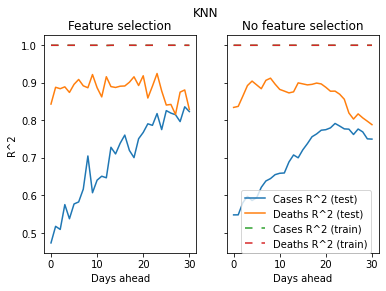

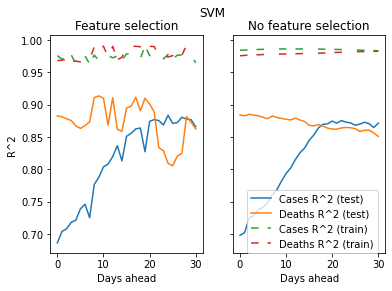

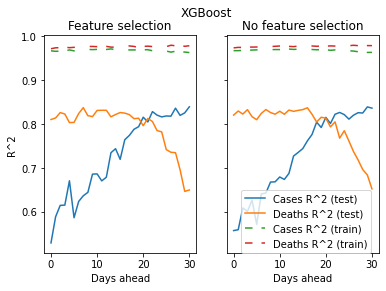

In [ ]:
results_KNN = results[results['algorithm'] == 'KNeighborsRegressor']
results_SVM = results[results['algorithm'] == 'SVR']
results_XGB = results[results['algorithm'] == 'XGBRegressor']
algo_results = {'KNN' : results_KNN,
                'SVM' : results_SVM,
                'XGBoost' : results_XGB}

def plot_algo_result(results, title):
  import matplotlib
  import matplotlib.pyplot as plt
  import matplotlib.gridspec as gridspec
  
  results_fs = results[results['feature_selection'] == True].sort_values('days_ahead')
  results_nfs = results[results['feature_selection'] == False].sort_values('days_ahead')

  results_fs_cases = results_fs[results_fs['target'] == 'cases_per_m']
  results_fs_deaths = results_fs[results_fs['target'] == 'deaths_per_m']
  results_nfs_cases = results_nfs[results_nfs['target'] == 'cases_per_m']
  results_nfs_deaths = results_nfs[results_nfs['target'] == 'deaths_per_m']

  fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True)
  fig.suptitle(title)
  ax1.plot(results_fs_cases['days_ahead'], results_fs_cases['r2_test'], label = 'Cases R^2 (test)')
  ax1.plot(results_fs_deaths['days_ahead'], results_fs_deaths['r2_test'], label = 'Deaths R^2 (test)')

  dashes = [5, 6, 5, 10]
  ax1.plot(results_fs_cases['days_ahead'], results_fs_cases['r2_train'], label = 'Cases R^2 (train)')[0].set_dashes(dashes)
  ax1.plot(results_fs_deaths['days_ahead'], results_fs_deaths['r2_train'], label = 'Deaths R^2 (train)')[0].set_dashes(dashes)

  ax1.title.set_text('Feature selection')
  ax1.set_xlabel('Days ahead')
  ax1.set_ylabel('R^2')
  
  ax2.plot(results_nfs_cases['days_ahead'], results_nfs_cases['r2_test'], label = 'Cases R^2 (test)')
  ax2.plot(results_nfs_deaths['days_ahead'], results_nfs_deaths['r2_test'], label = 'Deaths R^2 (test)')

  ax2.plot(results_nfs_cases['days_ahead'], results_nfs_cases['r2_train'], label = 'Cases R^2 (train)')[0].set_dashes(dashes)
  ax2.plot(results_nfs_deaths['days_ahead'], results_nfs_deaths['r2_train'], label = 'Deaths R^2 (train)')[0].set_dashes(dashes)

  ax2.title.set_text('No feature selection')
  ax2.set_xlabel('Days ahead')
  #ax2.get_yaxis().set_visible(False)

  ax2.legend(bbox_to_anchor=(0.95, 0.0), loc='lower right', borderaxespad=0.)
  
  plt.show()

for algo_name, algo_result in algo_results.items():
  plot_algo_result(algo_result, algo_name)


In [ ]:
results.iloc[102, 7]

Pipeline(steps=[('feature_transform',
                 ColumnTransformer(transformers=[('log_transform',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['smoothed_pct_tested_and_negative',
                                                   'smoothed_pct_tested_and_negative_weighted',
                                                   'smoothed_pct_tested_and_positive',
                                                   'smoothed_pct_tested_and_positive_weighted',
                                                   'smoothed_pct_tested_no_result',
                                                   'smoot...
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                      

In [ ]:
results_KNN = results[results['algorithm'] == 'KNeighborsRegressor']
results_SVM = results[results['algorithm'] == 'SVR']
results_XGB = results[results['algorithm'] == 'XGBRegressor']

pd.set_option('display.max_rows', None)
results


,algorithm,problem_type,days_ahead,target,test_pct,r2_train,r2_test,model_obj,features_kept,feature_selection
0,XGBRegressor,forecast,1,deaths_per_m,0.2,0.974883,0.829725,(ColumnTransformer(transformers=[('log_transfo...,all,False
1,XGBRegressor,forecast,1,cases_per_m,0.2,0.967455,0.559028,(ColumnTransformer(transformers=[('log_transfo...,all,False
2,XGBRegressor,forecast,2,deaths_per_m,0.2,0.974641,0.822821,(ColumnTransformer(transformers=[('log_transfo...,all,False
3,XGBRegressor,forecast,2,cases_per_m,0.2,0.967907,0.608684,(ColumnTransformer(transformers=[('log_transfo...,all,False
4,XGBRegressor,forecast,3,deaths_per_m,0.2,0.975594,0.832848,(ColumnTransformer(transformers=[('log_transfo...,all,False
5,XGBRegressor,forecast,3,cases_per_m,0.2,0.968159,0.600832,(ColumnTransformer(transformers=[('log_transfo...,all,False
6,XGBRegressor,forecast,4,deaths_per_m,0.2,0.975553,0.816710,(ColumnTransformer(transformers=[('log_transfo...,all,False
7,XGBRegressor,forecast,4,cases_per_m,0.2,0.968827,0.626523,(ColumnTransformer(transformers=[('log_transfo...,all,False
8,XGBRegressor,forecast,5,deaths_per_m,0.2,0.975733,0.809973,(ColumnTransformer(transformers=[('log_transfo...,all,False
9,XGBRegressor,forecast,5,cases_per_m,0.2,0.969145,0.571037,(ColumnTransformer(transformers=[('log_transfo...,all,False


In [ ]:

gpb_deaths = results_XGB[(results_XGB['target'] == 'deaths_per_m') & (results_XGB['feature_selection'] == True)]
gpb_cases = results_XGB[(results_XGB['target'] == 'cases_per_m') & (results_XGB['feature_selection'] == True)]

pd.Series(list(gpb_deaths['r2_test'].values - gpb_cases['r2_test'].values))

0     0.225379
1     0.211622
2     0.207840
3     0.132662
4     0.217427
5     0.200439
6     0.201058
7     0.174851
8     0.131260
9     0.144721
10    0.161039
11    0.152756
12    0.081985
13    0.077956
14    0.106776
15    0.060683
16    0.047341
17    0.024110
18    0.019361
19   -0.019378
20    0.007922
21   -0.022508
22   -0.035256
23   -0.034093
24   -0.076710
25   -0.082323
26   -0.101510
27   -0.124291
28   -0.179071
29   -0.189814
30    0.281455
dtype: float64

In [ ]:
# 20 day look-ahead XGBoost model:


xgb_regressor_20_deaths = results_XGB[(results_XGB.days_ahead == 20) & (results_XGB.feature_selection == True) & (results_XGB.target == 'deaths_per_m')].model_obj.values[0]
xgb_regressor_20_cases = results_XGB[(results_XGB.days_ahead == 20) & (results_XGB.feature_selection == True) & (results_XGB.target == 'cases_per_m')].model_obj.values[0]


## Miscellaneous Functionality

In [ ]:
def save_models_to_disk(models, dst):
    import os
    for model in models:
        pickle_and_dump(model, os.path.join(dst, model.name))

def read_models_from_disk(directory):
    import os
    models = []
    for pkl_file in os.listdir(directory):
        pkl_file_path = os.path.join(directory, pkl_file)
        models.append(read_pickle(pkl_file_path))
    return models

def pickle_and_dump(obj, path):
    from joblib import dump
    try:
        dump(obj, path)
    except FileNotFoundError as e:
        import os
        os.makedirs(os.path.split(path)[0])
    finally:
        dump(obj, path)

def read_pickle(path):
    from joblib import load
    return load(path)
    
def copy_to_host_command(src, dst):
    container_id = !cat /etc/hostname
    container_id = container_id[0]
    return f"docker cp {container_id}:{src} {dst}"

In [ ]:
import datetime
#curr_datetime = str(datetime.datetime.now())
#curr_datetime = '_'.join(curr_datetime.split(' '))
#model_dir = f'/auto-sklearn/auto-sklearn-output-dir/{curr_datetime}'
#save_models_to_disk(models, model_dir)

#host_model_dir = 'GitHub/covid-forecasting/models'

#print("Type this on the host machine to copy model pickles:\n")
#print(copy_to_host_command(model_dir, host_model_dir))

In [ ]:
def forecast(base_df, models):
    prediction_dfs = []
    
    for model in models:
        df = prepare_df_for_train_test_split(base_df, model.task, model.target, days_ahead = model.days_ahead)
        _, _, X, y_test = train_test_split_on_date(df, model.target, test_size = model.test_size)
        X.rename({'date' : 'date_forecasted'}, axis = 1, inplace = True)
                
        y_hat = model.predict(X.drop('date_forecasted', axis = 1))
        
        y_hat_col_name = f'predicted_{model.target}_{model.days_ahead}_days_ahead'
            
        prediction_df = pd.DataFrame({'date_present' : X['date_forecasted'],
                                      'state' : X.state_code.values,
                                      f'{model.target}_{model.days_ahead}_days_ahead' : y_test.values,
                                      y_hat_col_name : y_hat})
        
        prediction_dfs.append((model, prediction_df))
        
    return prediction_dfs

In [ ]:
def forecast_one_model(base_df, model, task, target, days_ahead, test_size):
  model.task = task
  model.target = target
  model.days_ahead = days_ahead
  model.test_size = test_size
  df = prepare_df_for_train_test_split(base_df, task, target, days_ahead = days_ahead)
  _, _, X, y_test = train_test_split_on_date(df, target, test_size = test_size)
  X.rename({'date' : 'date_forecasted'}, axis = 1, inplace = True)
          
  y_hat = model.predict(X.drop('date_forecasted', axis = 1))
  
  y_hat_col_name = f'predicted_{target}_{days_ahead}_days_ahead'
      
  prediction_df = pd.DataFrame({'date_present' : X['date_forecasted'],
                                'state' : X.state_code.values,
                                f'{target}_{days_ahead}_days_ahead' : y_test.values,
                                y_hat_col_name : y_hat})
  return (model, prediction_df)

In [ ]:
#models_from_disk = read_models_from_disk(model_dir)

#df = read_merged_csv('df.csv')
prediction_dfs = [forecast_one_model(df, xgb_regressor_20_deaths, 'forecast', 'deaths_per_m', 20, 0.2)]
prediction_dfs.append(forecast_one_model(df, xgb_regressor_20_cases, 'forecast', 'cases_per_m', 20, 0.2))


In [ ]:
def output_forecasting_results(prediction_dfs):
    results = []
    for model, prediction_df in prediction_dfs:
        if model.task == 'forecast':
            col_name = f'predicted_{model.target}_{model.days_ahead}_days_ahead'
            results.append(prediction_df.set_index(['date_present', 'state'], append = False))
    
    return results[0].join(results[1:]).reset_index().sort_values(['date_present', 'state'])
    
forecasting_report = output_forecasting_results(prediction_dfs)
forecasting_report.to_csv('/content/drive/My Drive/forecasting_report_20_days_ahead.csv',
                          index = False)

In [138]:
cases = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covidcsv/cases_per_m_20.csv')
deaths = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covidcsv/deaths_per_m_20.csv')

forecasting_report_20_days_ahead = cases[['date', 'state_code', 'actual_cases_per_m_20_days_ahead', 'predicted_cases_per_m_20_days_ahead']].join(deaths[['actual_deaths_per_m_20_days_ahead', 'predicted_deaths_per_m_20_days_ahead']])
forecasting_report_20_days_ahead.to_csv('/content/drive/My Drive/Colab Notebooks/covidcsv/forecasting_report_20_days_ahead.csv')